# Demonstration of Measurement
You'll using a a 4D time series in this notebook. Along the way, you'll learn the fundamentals of image segmentation, object labeling, and morphological measurement. 

This demo is a jupyter notebook, i.e. intended to be run step by step.

Author: Eric Einspänner
<br>
Contributor: Nastaran Takmilhomayouni

First version: 6th of July 2023


Copyright 2023 Clinic of Neuroradiology, Magdeburg, Germany

License: Apache-2.0

## Table of contents
1. [Initial set-up](#Initial-Set-Up)
2. [Load image/volume](#Load-the-Image/Volume)
3. [Segmentation](#Segmentation)
4. [Select objects](#Select-Objects)
5. [Extract objects](#Extract-Objects)
6. [Measure variance](#Measure-Variance)
7. [Separate histograms](#Separate-Histograms)
8. [Calculate distances](#Calculate-Distance)
9. [COM](#Center-of-Mass-COM)


## Initial Set-Up

In [1]:
# Make sure figures appears inline and animations works
# Edit this to ""%matplotlib notebook" when using the "classic" jupyter notebook interface
%matplotlib widget

In [2]:
# Initial imports etc
import pydicom
from pydicom.data import get_testdata_file
import imageio
import numpy as np
import scipy.ndimage as ndi
import matplotlib.pyplot as plt

In [3]:
def format_and_render_plot():
    '''Custom function to simplify common formatting operations for exercises. Operations include: 
    1. Turning off axis grids.
    2. Calling `plt.tight_layout` to improve subplot spacing.
    3. Calling `plt.show()` to render plot.'''
    fig = plt.gcf()
    for ax in fig.axes:
        ax.axis('off')    
    plt.tight_layout()
    plt.show()

## Load the Image/Volume

In [7]:
# Load the directory (volume)
#folder_path = 'C:/Users/einspaen/Downloads/Biomedical-Image-Analysis-in-Python-master/Biomedical-Image-Analysis-in-Python-master/Data/Brain/SE000001/MR000000'
folder_path = 'Data/SE000001/MR000000'

vol = imageio.volread(folder_path)

# save the middle slice as separat image
im = vol[13,:,:]

Reading DICOM (examining files): 1/27 files (3.7%27/27 files (100.0%)
  Found 1 correct series.
Reading DICOM (loading data): 27/27  (100.0%)


Data type: float64
Min. value: 0.0
Max value: 1.0


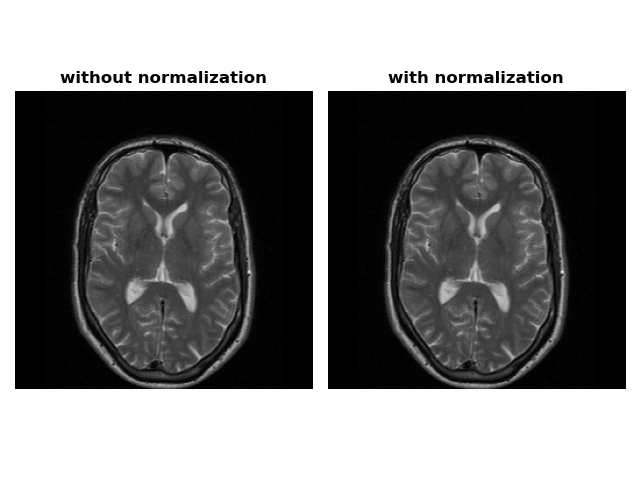

In [8]:
# min-max normalisation
im_old = im
im = (im - im.min()) / (im.max() - im.min())

# Print the image's data type, minimum and maximum intensity
print('Data type:', im.dtype)
print('Min. value:', im.min())
print('Max value:', im.max())

# Plot the grayscale images
fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].imshow(im_old, cmap='gray')
axes[0].set_title('without normalization', fontweight ="bold")
axes[1].imshow(im, cmap='gray')
axes[1].set_title('with normalization', fontweight ="bold")
format_and_render_plot()

## Segmentation
In this chapter, we'll work with magnetic resonance (MR) imaging data. The full image is a 3D time series spanning ...

In [9]:
# Smooth intensity values
im_filt = ndi.median_filter(im, size=3)

# Select high-intensity pixels
mask_start = np.where(im_filt > 0.3, 1, 0)
mask = ndi.binary_closing(mask_start)

# Label the objects in "mask"
labels, nlabels = ndi.label(mask)
print('Num. Labels:', nlabels)

Num. Labels: 25


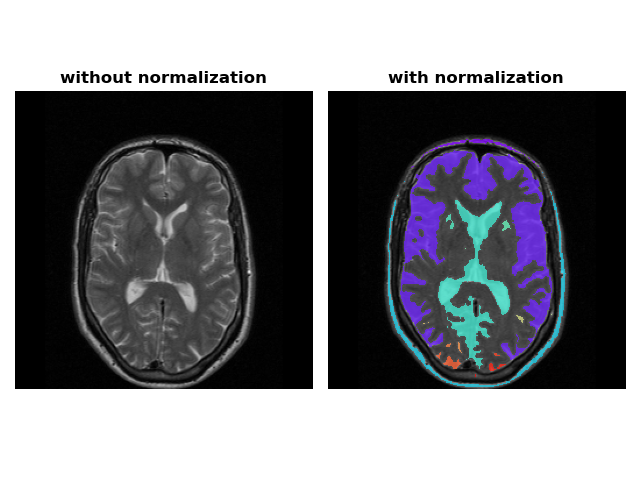

In [10]:
# Create a `labels` overlay
overlay = np.where(labels > 0, labels, np.nan)

# Use imshow to plot the overlay
plt.imshow(overlay, cmap='rainbow', alpha=0.75)
format_and_render_plot()

## Select Objects
Labels are like object "handles" - they give you a way to pick up whole sets of pixels at a time. To select a particular object:

1. Find the label value associated with the object.
2. Create a mask of matching pixels.

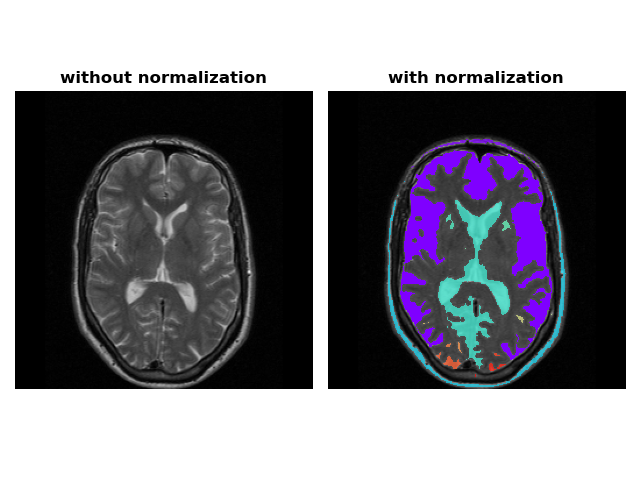

In [11]:
# Label the image "mask"
labels, nlabels = ndi.label(mask)

# Select gray matter (gm)
gm_val = labels[113, 90]
gm_mask = np.where(labels == gm_val, 1, np.nan)

# Overlay selected label
plt.imshow(gm_mask, cmap='rainbow')
plt.show()

## Extract Objects
Extracting objects from the original image eliminates unrelated pixels and provides new images that can be analyzed independently.

The key is to crop images so that they only include the object of interest. The range of pixel indices that encompass the object is the bounding box.

[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]
int64
Number of objects: 1
Indices for first box: (slice(50, 234, None), slice(61, 193, None))


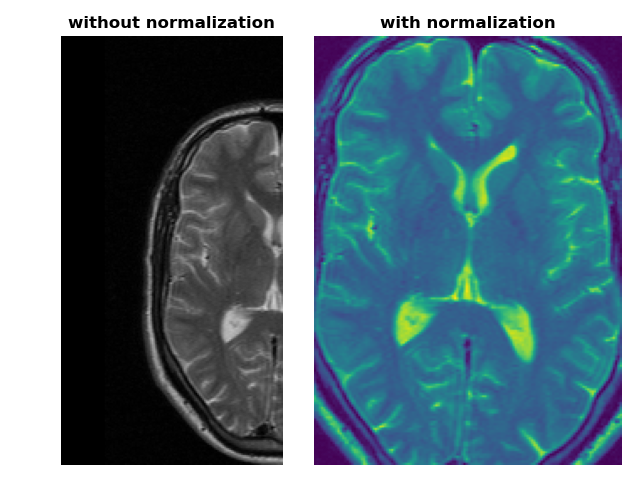

In [19]:
print(gm_mask)
gm_mask=gm_mask.astype(np.int64)
print(gm_mask.dtype)
# Find bounding box
bboxes =ndi.find_objects(gm_mask)
print('Number of objects:', len(bboxes))
print('Indices for first box:', bboxes[0])

# Crop to index 0
im_gm = im[bboxes[0]]

# Plot the cropped image
plt.imshow(im_gm)
format_and_render_plot()

## Measure Variance
SciPy measurement functions allow you to tailor measurements to specific sets of pixels:

- Specifying `labels` restricts the mask to non-zero pixels.
- Specifying `index` value(s) returns a measure for each label value.

For this exercise, calculate the intensity variance of `vol` with respect to different pixel sets. We have provided the 3D segmented image as `labels`: label 1 is the left ventricle and label 2 is a circular sample of tissue.

In [20]:
# Variance for all pixels
var_all = ndi.variance(vol, labels=None, index=None)
print('All pixels:', var_all)

# Variance for labeled pixels
var_labels = ndi.variance(vol, labels, index=None)
print('Labeled pixels:', var_labels)

# Variance for each object
var_objects = ndi.variance(vol, labels, index=[1,2])
print('Gray matter:', var_objects[0])
print('Other tissue:', var_objects[1])

All pixels: 15281.189220274951
Labeled pixels: 18188.560688187546
Gray matter: 13466.402775068886
Other tissue: 16319.82340391041


## Separate Histograms
A poor tissue segmentation includes multiple tissue types, leading to a wide distribution of intensity values and more variance.

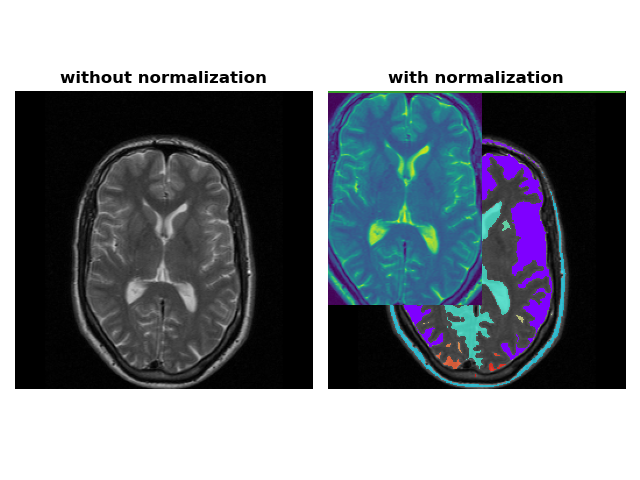

In [21]:
# Create histograms for selected pixels
hist1 = ndi.histogram(vol, min=0, max=255, bins=256)
hist2 = ndi.histogram(vol, 0, 255, 256, labels=labels)
hist3 = ndi.histogram(vol, 0, 255, 256, labels=labels, index=1)

# Plot the histogram density
plt.plot(hist1 / hist1.sum(), label='All pixels')
plt.plot(hist2 / hist2.sum(), label='All labeled pixels')
plt.plot(hist3 / hist3.sum(), label='Left ventricle')
format_and_render_plot()

## Calculate Distance
A distance transformation calculates the distance from each pixel to a given point, usually the nearest background pixel. This allows you to determine which points in the object are more interior and which are closer to edges.

In this exercise, use the Euclidian distance transform.

In [22]:
# Calculate distances
gm = np.where(labels == 1, 1, 0)
dists = ndi.distance_transform_edt(gm, sampling=vol.meta['sampling'])

# Report on distances
print('Max distance (mm):', ndi.maximum(dists))
print('Max location:', ndi.maximum_position(dists))

# Plot overlay of distances
overlay = np.where(dists[5] > 0, dists[5], np.nan) 
plt.imshow(overlay, cmap='hot')
format_and_render_plot()

RuntimeError: sequence argument must have length equal to input rank

## Center-Of-Mass (COM)
The distance transformation reveals the most embedded portions of an object. On the other hand, `ndi.center_of_mass()` returns the coordinates for the center of an object.

The "mass" corresponds to intensity values, with higher values pulling the center closer to it.

Label 1 center: (8.856682792208547, 49.44438084201855, 125.03554483621987)
Label 2 center: (11.713445688803832, 119.3292456288401, 129.36906622106693)


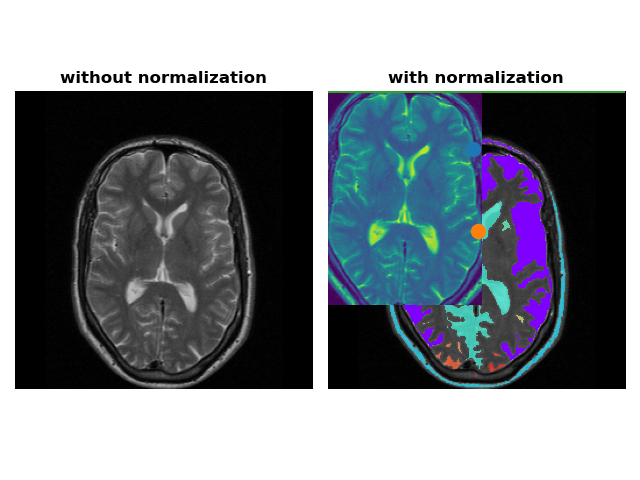

In [23]:
# Extract centers of mass for objects 1 and 2
coms = ndi.center_of_mass(vol, labels, index=[1,2])
print('Label 1 center:', coms[0])
print('Label 2 center:', coms[1])

# Add marks to plot
for c0, c1, c2 in coms:
    plt.scatter(c2, c1, s=100, marker='o')
plt.show()